In [1]:
!git clone https://github.com/deepanshudashora/custom_models.git

Cloning into 'custom_models'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 25 (delta 7), reused 14 (delta 4), pack-reused 0
Unpacking objects: 100% (25/25), 7.87 KiB | 1.12 MiB/s, done.


In [2]:
!pip3 install torch_lr_finder
!pip3 install torchinfo

In [3]:
# Initialized Logger
import torch
import torch.optim as optim
from torchvision import datasets
import albumentations as A
from torchinfo import summary
from albumentations.pytorch import ToTensorV2
from custom_models.utils import get_device, \
                  fit_model, plot_accuracy_report, \
                  show_random_results, plot_misclassified, \
                  calculate_accuracy_per_class
from custom_models.dataset import dataset_stats,\
                        visualize_images,\
                        visualize_augmentated_images,\
                        Cifar10SearchDataset
from custom_models.custom_resnet import CustomResnet

In [4]:
# CUDA?
device = get_device()
print("Available Device :: ", device)

INFO:custom_models.utils:device: cuda


Available Device ::  cuda


CODE BLOCK: 3

In [5]:
sample = datasets.CIFAR10('./data',train=True,download=True)
sample_data = sample.data

mean,std,var = dataset_stats(sample_data)
print(f"SHAPE of Images {sample_data.shape}")
print(f"MEAN of dataset {mean}")
print(f"STD of dataset {std}")
print(f"VAR of dataset {var}")

100%|██████████| 170498071/170498071 [00:01<00:00, 92575979.25it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
SHAPE of Images (50000, 32, 32, 3)
MEAN of dataset [0.49139968 0.48215841 0.44653091]
STD of dataset [0.24703223 0.24348513 0.26158784]
VAR of dataset [15.56135559 15.11767693 17.44919073]


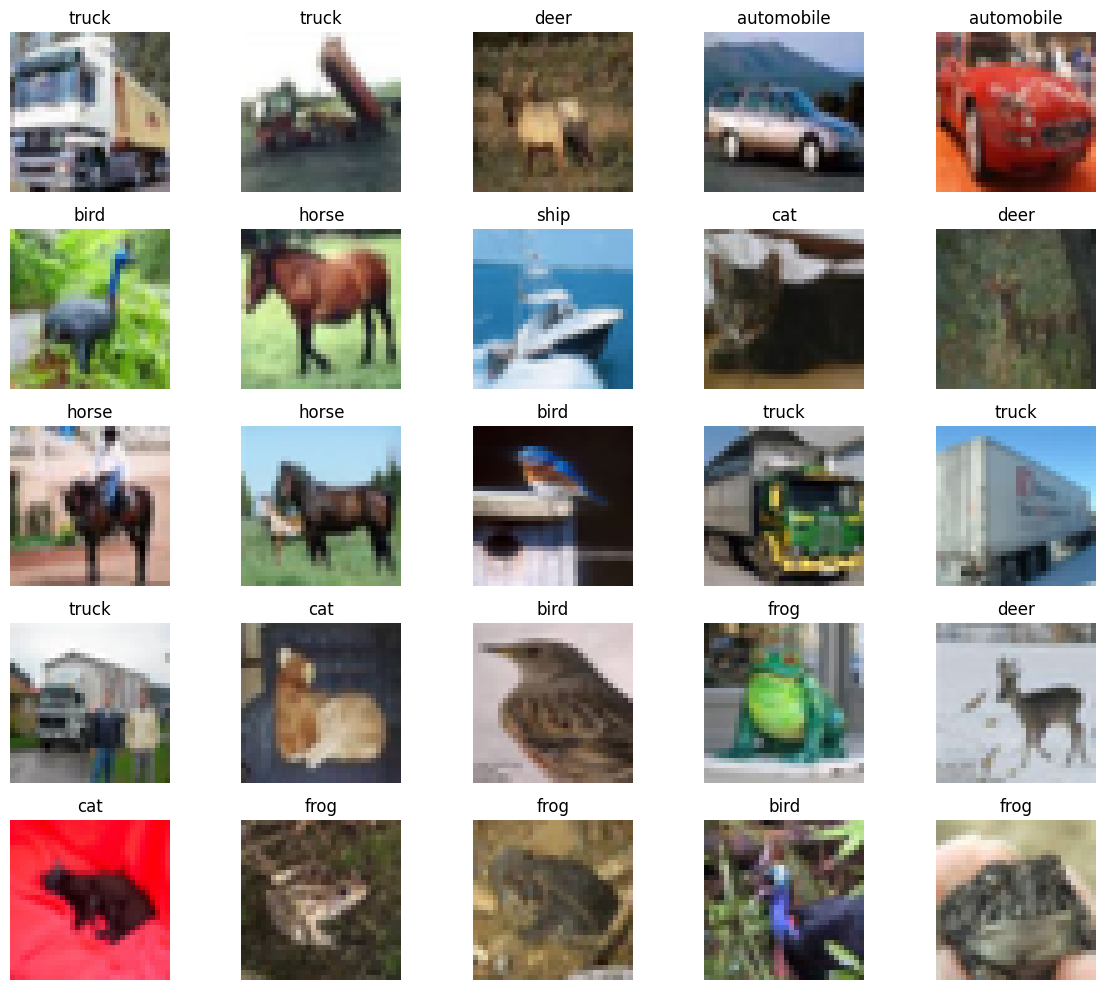

In [6]:
visualize_images(sample,(5,5))

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:133: FutureWarning: IAAFliplr is deprecated. Please use HorizontalFlip instead.
  warnings.warn("IAAFliplr is deprecated. Please use HorizontalFlip instead.", FutureWarning)


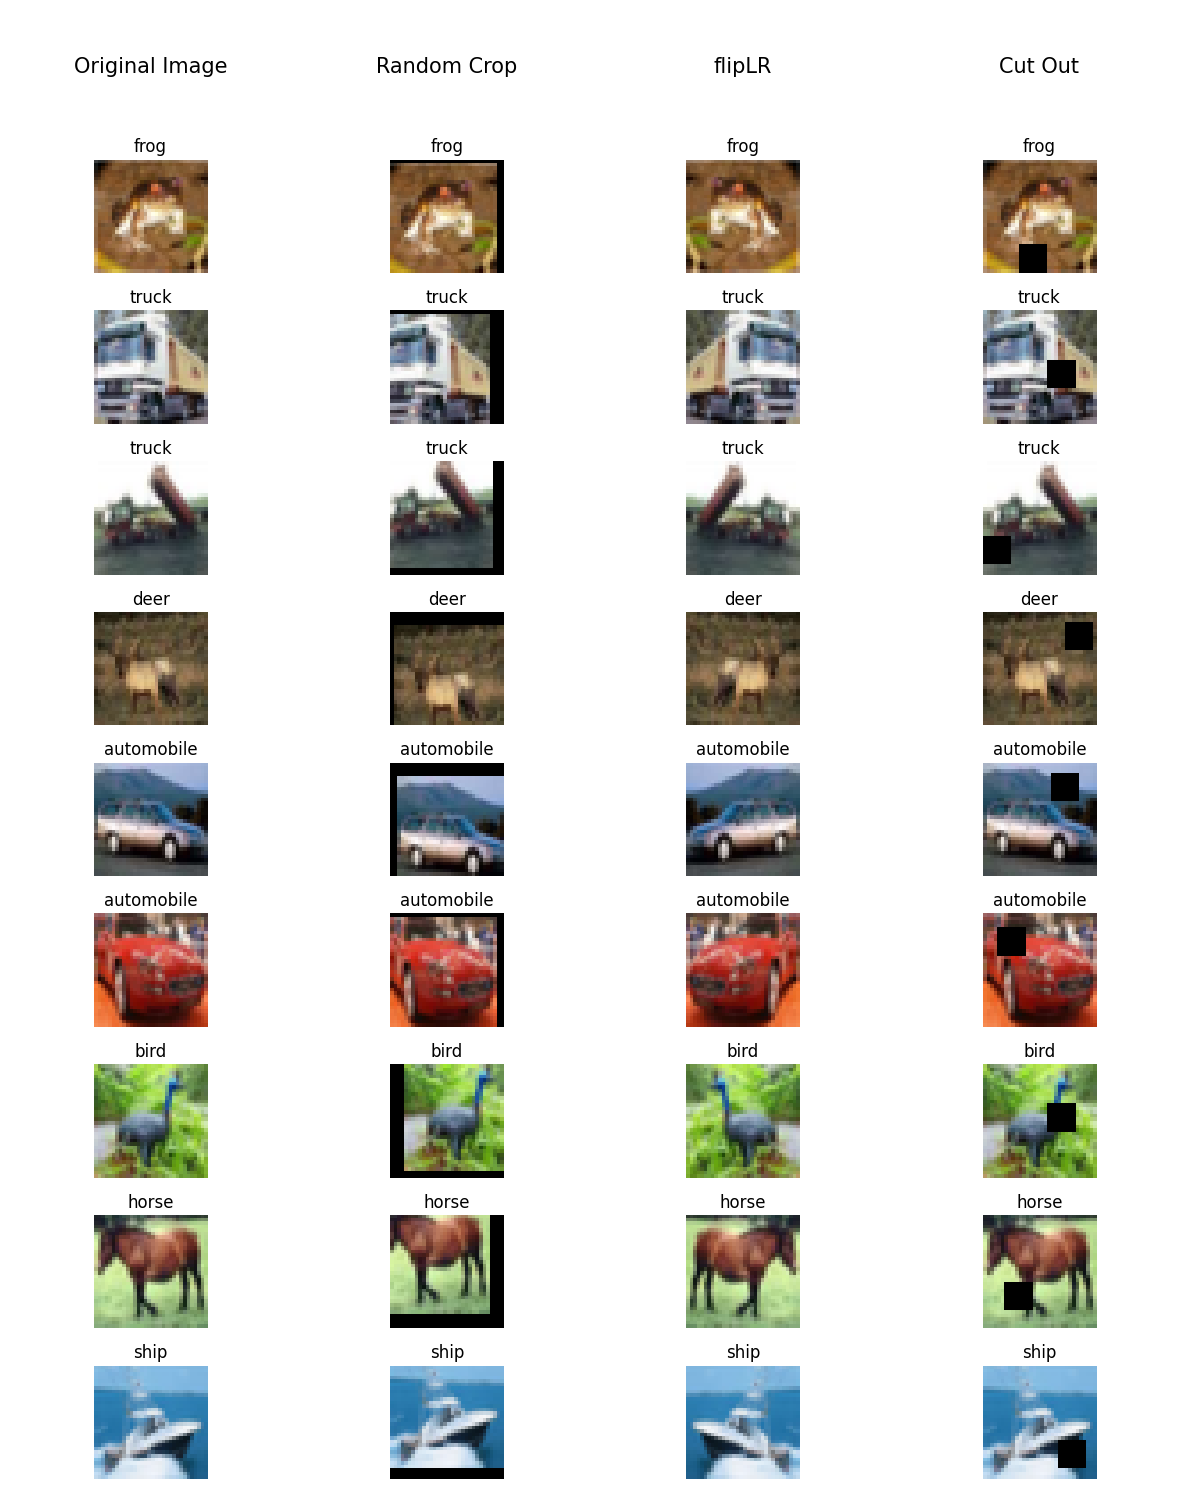

In [7]:
aug_details = {
    'Original Image': None,
    'Random Crop': A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 4, keep_size=True by default
                  A.RandomCrop(32,32)]),
    'flipLR':A.IAAFliplr (always_apply=True),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8,
                               min_width=8, fill_value=[0.49139968, 0.48215841, 0.44653091], always_apply=True),
      }

visualize_augmentated_images(sample,aug_details)

In [8]:
train_transforms = A.Compose(
    [
      A.Normalize(mean, std),
      # A.PadIfNeeded(40, 40, p=1),
      # A.RandomCrop(32, 32, p=1),
      A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 4, keep_size=True by default
                        A.RandomCrop(32,32)])
      A.IAAFliplr(always_apply=True),
      A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8,
                            min_width=8, fill_value=[0.49139968, 0.48215841, 0.44653091], always_apply=True),
      ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
      A.Normalize(mean, std),
      ToTensorV2(),
    ]
)

train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


In [10]:
model = CustomResnet().to(device)
summary(model, input_size=(512,3, 32, 32),depth=4)

Layer (type:depth-idx)                   Output Shape              Param #
CustomResnet                             [512, 10]                 --
├─Sequential: 1-1                        [512, 64, 32, 32]         --
│    └─Conv2d: 2-1                       [512, 64, 32, 32]         1,728
│    └─BatchNorm2d: 2-2                  [512, 64, 32, 32]         128
│    └─ReLU: 2-3                         [512, 64, 32, 32]         --
├─Sequential: 1-2                        [512, 128, 16, 16]        --
│    └─Conv2d: 2-4                       [512, 128, 32, 32]        73,728
│    └─MaxPool2d: 2-5                    [512, 128, 16, 16]        --
│    └─BatchNorm2d: 2-6                  [512, 128, 16, 16]        256
│    └─ReLU: 2-7                         [512, 128, 16, 16]        --
├─Sequential: 1-3                        [512, 128, 16, 16]        --
│    └─Conv2d: 2-8                       [512, 128, 16, 16]        147,456
│    └─BatchNorm2d: 2-9                  [512, 128, 16, 16]        256


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.87E-02


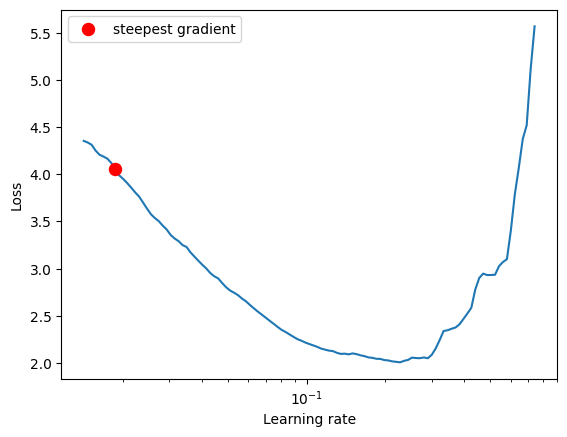

In [11]:
# LR calculation
from torch_lr_finder import LRFinder

model = CustomResnet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [12]:
training_parameters = {"learning_rate":0.01,
                       "max_lr":1.87E-02,
                       "max_at":5/24,
                       "num_epochs":24,
                       "weight_decay":1e-4
                       }
train_losses, test_losses, train_acc, test_acc = fit_model(model,training_parameters,train_loader,test_loader,device)

Epoch 1


Train: Loss=0.9490 Batch_id=97 Accuracy=50.59: 100%|██████████| 98/98 [00:53<00:00,  1.85it/s]


Test set: Average loss: 0.0386, Accuracy: 5172/10000 (51.72%)

Epoch 2


Train: Loss=0.7590 Batch_id=97 Accuracy=66.25: 100%|██████████| 98/98 [00:53<00:00,  1.85it/s]


Test set: Average loss: 0.0235, Accuracy: 6931/10000 (69.31%)

Epoch 3


Train: Loss=0.9701 Batch_id=97 Accuracy=72.90: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.0285, Accuracy: 6754/10000 (67.54%)

Epoch 4


Train: Loss=0.7411 Batch_id=97 Accuracy=75.39: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Test set: Average loss: 0.0205, Accuracy: 7604/10000 (76.04%)

Epoch 5


Train: Loss=0.6207 Batch_id=97 Accuracy=77.68: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Test set: Average loss: 0.0212, Accuracy: 7247/10000 (72.47%)

Epoch 6


Train: Loss=0.5695 Batch_id=97 Accuracy=79.17: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Test set: Average loss: 0.0181, Accuracy: 7902/10000 (79.02%)

Epoch 7


Train: Loss=0.6019 Batch_id=97 Accuracy=80.96: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Test set: Average loss: 0.0125, Accuracy: 8119/10000 (81.19%)

Epoch 8


Train: Loss=0.5925 Batch_id=97 Accuracy=81.60: 100%|██████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.0185, Accuracy: 7628/10000 (76.28%)

Epoch 9


Train: Loss=0.5473 Batch_id=97 Accuracy=82.24: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.0121, Accuracy: 8160/10000 (81.60%)

Epoch 10


Train: Loss=0.4864 Batch_id=97 Accuracy=83.27: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.0177, Accuracy: 8023/10000 (80.23%)

Epoch 11


Train: Loss=0.4858 Batch_id=97 Accuracy=83.58: 100%|██████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.0173, Accuracy: 7972/10000 (79.72%)

Epoch 12


Train: Loss=0.6261 Batch_id=97 Accuracy=84.31: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Test set: Average loss: 0.0144, Accuracy: 8339/10000 (83.39%)

Epoch 13


Train: Loss=0.4370 Batch_id=97 Accuracy=84.85: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.0153, Accuracy: 8188/10000 (81.88%)

Epoch 14


Train: Loss=0.4110 Batch_id=97 Accuracy=85.23: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.0155, Accuracy: 8204/10000 (82.04%)

Epoch 15


Train: Loss=0.3817 Batch_id=97 Accuracy=85.99: 100%|██████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.0164, Accuracy: 8149/10000 (81.49%)

Epoch 16


Train: Loss=0.4587 Batch_id=97 Accuracy=86.68: 100%|██████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.0160, Accuracy: 8412/10000 (84.12%)

Epoch 17


Train: Loss=0.3425 Batch_id=97 Accuracy=87.71: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.0121, Accuracy: 8561/10000 (85.61%)

Epoch 18


Train: Loss=0.3654 Batch_id=97 Accuracy=88.56: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Test set: Average loss: 0.0134, Accuracy: 8535/10000 (85.35%)

Epoch 19


Train: Loss=0.3320 Batch_id=97 Accuracy=89.39: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Test set: Average loss: 0.0107, Accuracy: 8588/10000 (85.88%)

Epoch 20


Train: Loss=0.1886 Batch_id=97 Accuracy=90.88: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.0095, Accuracy: 8672/10000 (86.72%)

Epoch 21


Train: Loss=0.2095 Batch_id=97 Accuracy=91.76: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Test set: Average loss: 0.0093, Accuracy: 8832/10000 (88.32%)

Epoch 22


Train: Loss=0.1929 Batch_id=97 Accuracy=93.69: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.0086, Accuracy: 8981/10000 (89.81%)

Epoch 23


Train: Loss=0.1346 Batch_id=97 Accuracy=95.24: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.0110, Accuracy: 9104/10000 (91.04%)

Epoch 24


Train: Loss=0.0887 Batch_id=97 Accuracy=96.93: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.0073, Accuracy: 9180/10000 (91.80%)



In [13]:
test_loss_cpu = []
for i in test_losses:
  test_loss_cpu.append(i.cpu().numpy())

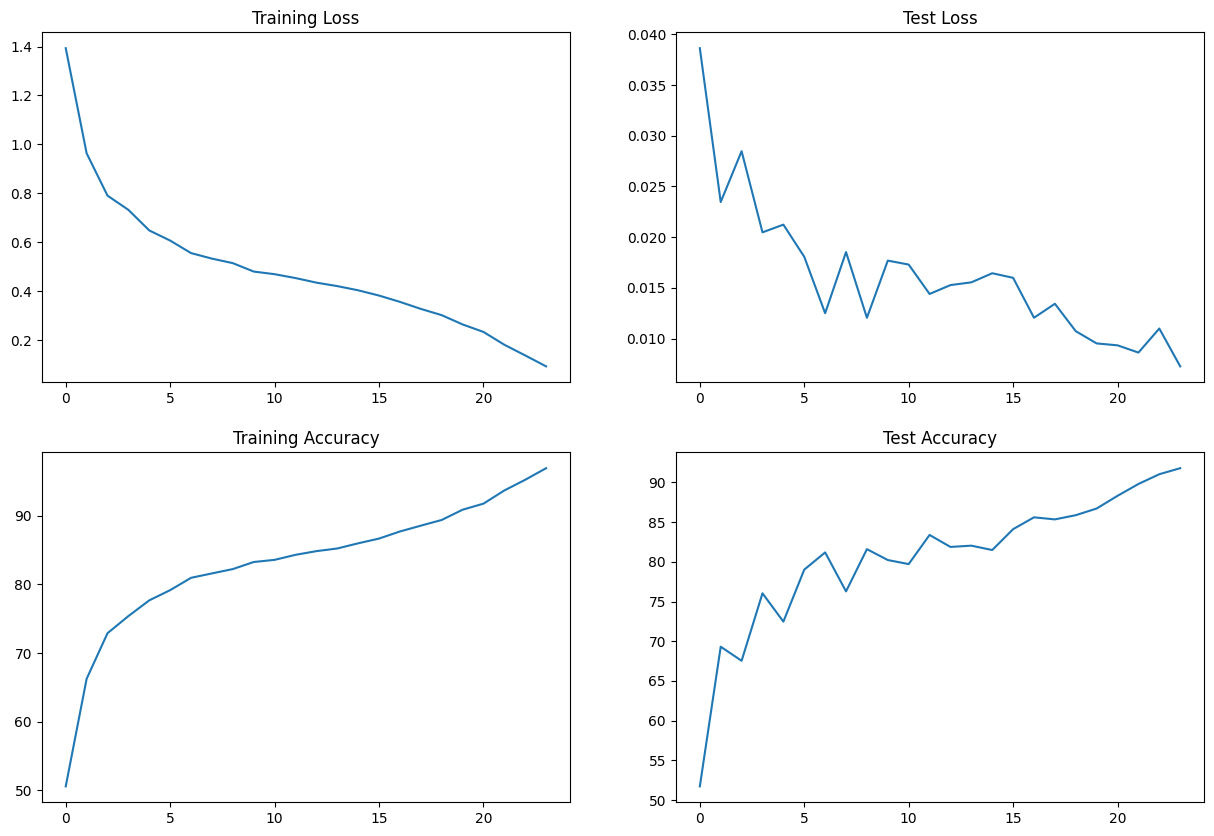

In [14]:
plot_accuracy_report(train_losses, test_loss_cpu, train_acc, test_acc)

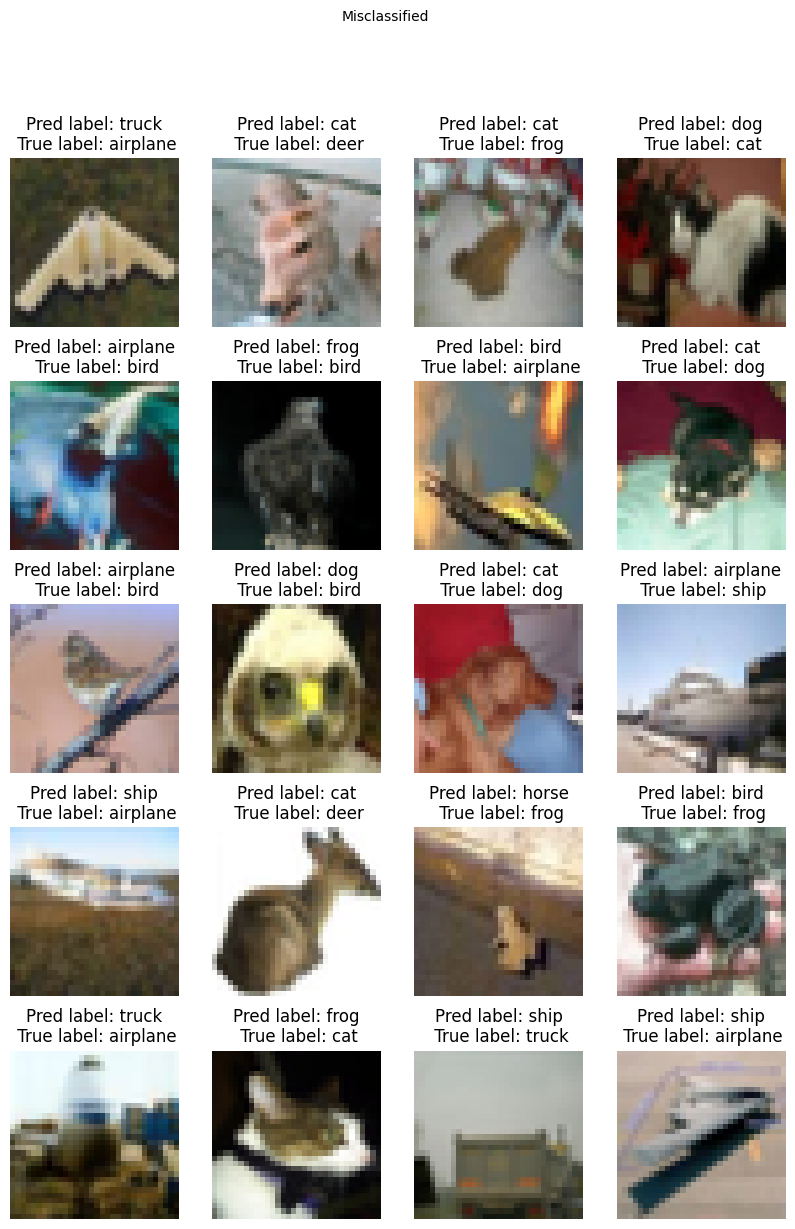

In [15]:
# from torchvision import transforms
# import matplotlib.pyplot as plt
# import numpy as np

grid_size = (4,4)
plot_misclassified(model,test_loader,test,device,mean,std)


Accuracy of airplane : 76 %

Accuracy of automobile : 95 %

Accuracy of  bird : 86 %

Accuracy of   cat : 76 %

Accuracy of  deer : 92 %

Accuracy of   dog : 100 %

Accuracy of  frog : 95 %

Accuracy of horse : 100 %

Accuracy of  ship : 100 %

Accuracy of truck : 87 %
{'airplane': 76.92307692307692, 'automobile': 95.45454545454545, 'bird': 86.95652173913044, 'cat': 76.19047619047619, 'deer': 92.0, 'dog': 100.0, 'frog': 95.45454545454545, 'horse': 100.0, 'ship': 100.0, 'truck': 87.5}


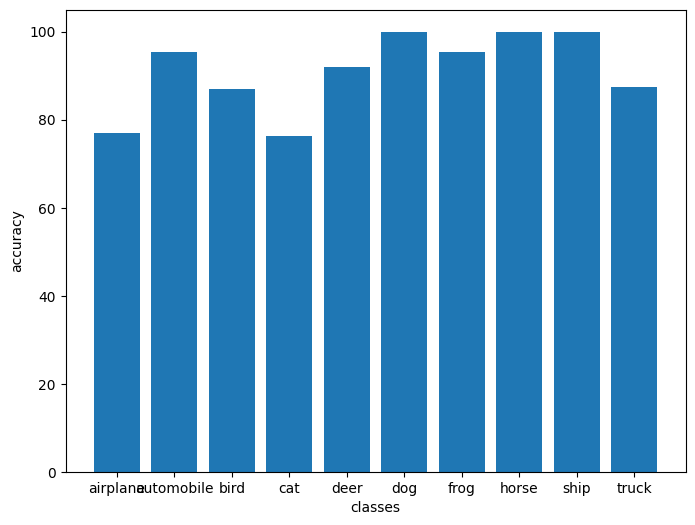

In [16]:
calculate_accuracy_per_class(model,device,test_loader,test)

In [17]:
torch.save(model.state_dict(), "cifar_85.pth")